### Binning demonstration on locally generated fake data
In this example, we generate a table with random data simulating a single event dataset.
We showcase the binning method, first on a simple single table using the bin_partition method and then in the distributed mehthod bin_dataframe, using daks dataframes.
The first method is never really called directly, as it is simply the function called by the bin_dataframe on each partition of the dask dataframe.

In [17]:
import sys

import dask
import numpy as np
import pandas as pd
import dask.dataframe

import matplotlib.pyplot as plt



sys.path.append("../")
from sed.binning import bin_partition, bin_dataframe

## Generate Fake Data

In [18]:
n_pts = 100000
cols = ["posx", "posy", "energy"]
df = pd.DataFrame(np.random.randn(n_pts, len(cols)), columns=cols)
df

,posx,posy,energy
0,2.032179,1.184606,-2.412525
1,-0.575859,0.500391,0.257476
2,0.613890,-0.656669,-0.357802
3,-0.015317,0.023137,2.690879
4,-1.069712,-1.666851,-0.169090
...,...,...,...
99995,-0.851950,0.464470,0.135173
99996,0.093806,-0.914713,0.556898
99997,1.277553,0.320370,0.188919
99998,0.792937,-1.599118,1.518680


## Define the binning range

In [19]:
binAxes = ["posx", "posy", "energy"]
nBins = [120, 120, 120]
binRanges = [(-2, 2), (-2, 2), (-2, 2)]
coords = {ax: np.linspace(r[0], r[1], n) for ax, r, n in zip(binAxes, binRanges, nBins)}

## Compute the binning along the pandas dataframe

In [20]:
%%time
res = bin_partition(
    part=df,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

CPU times: user 11.8 ms, sys: 1.85 ms, total: 13.7 ms
Wall time: 10 ms


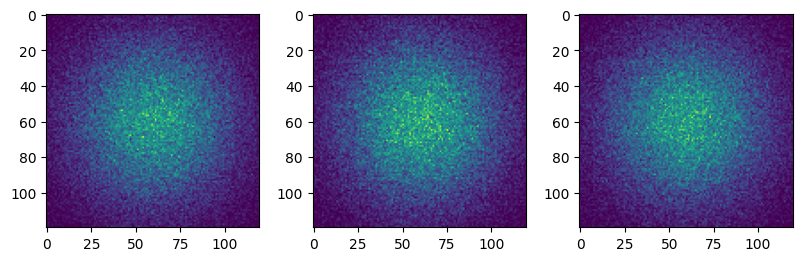

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for i in range(3):
    axs[i].imshow(res.sum(i))

## Transform to dask dataframe

In [22]:
ddf = dask.dataframe.from_pandas(df, npartitions=50)
ddf

,posx,posy,energy
npartitions=50,,,
0,float64,float64,float64
2000,...,...,...
...,...,...,...
98000,...,...,...
99999,...,...,...


## compute distributed binning on the partitioned dask dataframe
In this example, the small dataset does not give significant improvement over the pandas implementation, at least using this number of partitions.
A single partition would be faster (you can try...) but we use multiple for demonstration purpouses.

In [23]:
%%time
res = bin_dataframe(
    df=ddf,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 644 ms, sys: 331 ms, total: 975 ms
Wall time: 479 ms


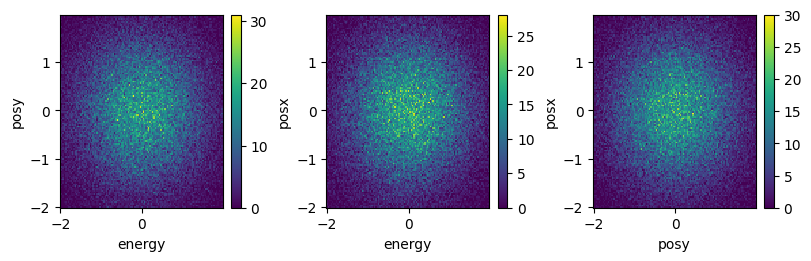

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for dim, ax in zip(binAxes, axs):
    res.sum(dim).plot(ax=ax)